In [1]:
import numpy as np
import scipy.stats as spst
import scipy.sparse as spsp
from sif.models import BayesianLogisticRegression
from sif.models.sigmoid import sigmoid
from sif.samplers import multivariate_normal_sampler

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# Part One: Introduction

In this exposition I am considering a stochastic differential equation to draw samples from a normal distribution. The main tool of theoretical interest is the Fokker-Planck equation, which can describe the stationary distribution of the dynamics in infinite time. Consider the following stochastic differential equation,
\begin{align}
\mathop{d}X_t = -\nabla V(X_t) \mathop{d}t + \sqrt{2D}\mathop{d}B_t
\end{align}
where $V : \mathbb{R}\to\mathbb{R}$ is a potential. The object $\mathop{d}B_t$ refers to the change in Brownian motion over an infinitesimal period of time. (I have sometimes encountered the following notation for $\mathop{d}B_t$ which I find unusual and may just be a heuristic to aid intuition: $\mathop{d}B_t \sim\mathcal{N}(0, \mathop{d}t)$.) When these dynamics are run forward in time, they specify the random position of a particle at time $t$, denoted $X_t$. An object of interest for us is the probability density of being in position $x$ at time $t$, which I denote by $p_X(x, t)$. The Fokker-Planck equation says that these dynamics have a stationary distribution in the limit of infinite time and that this distribution has an explicit form as,
\begin{align}
p_s(x) &= \lim_{t\to\infty} p_X(x, t) \\
&\propto \exp\left(-V(x) / D\right)
\end{align}

The stationary distribution suggests a convenient mechanism for drawing samples from an arbitrary probability distribution $p_t(x)$:

1. Write the negative log-density of the target probability density and call this the potential $V(x)=-\log p_t(x)$.
2. Obtain the corresponding stochastic differential equation with $D=1$ and observe that its stationary distribution is $p_t(x)$.
3. Transform the continuous time stochastic differential equation into a discrete time difference equation via this recipe: $\mathop{d}X_t \to \Delta X_t = X_{t+1}-X_t$, $\mathop{d}t\to\Delta t$ (a small positive number representing discretization of time), and $\mathop{d}B_t\to \Delta B_t\sim \mathcal{N}(0, \Delta t)$.
4. Run the difference equation forward in time and hope that the discretization is fine enough to obtain samples from the target distribution.

To begin this notebook, I'll consider a specific example of a target distribution and apply this scheme for drawing samples from it. This distribution will be simple enough to directly observe convergence of the samples to the desired probability density. The potential is,
\begin{align}
V(x) &= \frac{(x-\mu)^2}{2\sigma^2} \\
\nabla_x V(x) &= \frac{x-\mu}{\sigma^2}
\end{align}
The corresponding stochastic differential equation and difference equation are,
\begin{align}
\mathop{d}X_t &= -\frac{X_t-\mu}{\sigma^2} \mathop{d}t + \sqrt{2}\mathop{d}B_t \\
\Delta X_t &= -\frac{X_t-\mu}{\sigma^2} \Delta t + \sqrt{2} \Delta B_t
\end{align}
Notice that by the Fokker-Planck equation we know the stationary distribution of these dynamics.
\begin{align}
p_s(x) &\propto \exp\left(-V(x)\right) \\
&= \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
\end{align}
which we recognize as the kernel of a Gaussian distribution; hence, the stationary distribution is $\mathcal{N}(\mu,\sigma^2)$. As a specific example, consider $\mu=3$ and $\sigma^2=4$.

In [3]:
mu = 3.
sigma = np.sqrt(4)

We need to set a discretization of time in order to run the stochastic dynamics. There is a trade-off here in the sense that smaller $\Delta t$ will produce a higher fidelity simulation of the continuous time dynamics but will also be slower to converge. For this example, I will discretely evolve the system every $1/10$ "units of time." I will evolve the system for a large number of iterations in order to approximate the stationary distribution of the dynamics.

In [4]:
Delta_t = 1. / 10
n_iter = 1000000

This next portion of code implements these dynamics. One can see that the "recipe" is followed precisely. As a final step, I visualize a probability histogram of the discrete time iterates emerging from these dynamics and observe that they do indeed represent a large random sample from the desired target probability distribution.

In [5]:
X = np.zeros((n_iter, ))
for i in range(1, n_iter):
    Delta_X = (
        -(X[i-1] - mu) / (sigma**2) * Delta_t + 
        np.sqrt(2) * np.random.normal(scale=np.sqrt(Delta_t)))
    X[i] = X[i-1] + Delta_X

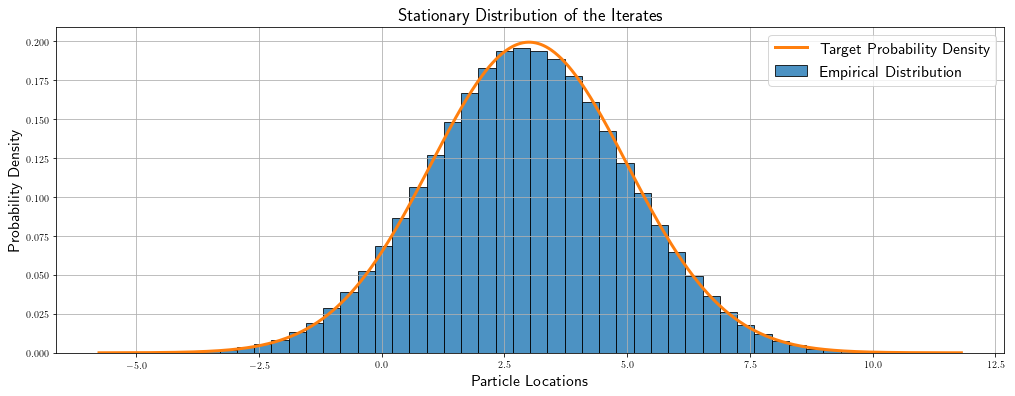

In [6]:
r = np.linspace(X.min(), X.max(), 1000)
plt.figure(figsize=(17, 6))
plt.hist(X, bins=50, density=True, edgecolor="black", alpha=0.8, 
         label="Empirical Distribution")
plt.plot(r, spst.norm.pdf(r, mu, sigma), linewidth=3, 
         label="Target Probability Density")
plt.grid()
plt.legend(fontsize=16)
plt.xlabel("Particle Locations", fontsize=16)
plt.ylabel("Probability Density", fontsize=16)
plt.title("Stationary Distribution of the Iterates", fontsize=18)
plt.show()

# Part Two: Logistic Regression

In this section I will consider the problem of sampling from the posterior of a Bayesian logistic regression model. Suppose that we fix an input $\mathbf{x}\in\mathbb{R}^2$. we can define a generative model according to
\begin{align}
\theta&\sim\mathcal{N}(\mathbf{0}, \lambda^{-2}\mathbf{I}) \\
Y\vert\theta, \mathbf{x} &\sim \text{Bern}\left(\sigma(\mathbf{x}^\top \theta)\right)
\end{align}
The objective of Bayesian logistic regression is to infer a posterior distribution over $\theta$ given a collection of data points $\mathcal{D}=\left\{(\mathbf{x}_1, y_1),\ldots, (\mathbf{x}_n, y_n)\right\}$. If these observations are independent, we know that the posterior distribution will be proportional to,
\begin{align}
p(\theta\vert \mathcal{D}) \propto \left(\prod_{i=1}^n \sigma(\mathbf{x}_i^\top \theta)^{y_i} (1-\sigma(\mathbf{x}_i^\top \theta))^{1-y_i}\right) \left(\frac{\lambda^2}{\sqrt{2\pi}} \exp\left(-\lambda^2\frac{\theta^\top\theta}{2}\right)\right)
\end{align}
Some algebra and calculus shows that the derivative of the potential for this posterior distribution can be written as
\begin{align}
\nabla_\theta V(\theta) = -\sum_{i=1}^n \left(y - \sigma(\mathbf{x}_i^\top \theta)\right) \mathbf{x}_i + \lambda^{2} \theta
\end{align}
The corresponding stochastic differential equation to sample from this posterior is
\begin{align}
\mathop{d}\theta_t = -\nabla_\theta V(\theta_t) + \sqrt{2} \mathop{d}B_t
\end{align}

I begin by simulating a logistic regression problem with $n$ observations and $\mathbf{x}_{ij}\sim\mathcal{N}(0, 4)$. I set the true linear coefficients to be $\theta^\star = (2, -1)$.

In [7]:
n = 500
X = np.random.normal(scale=2, size=(n, 2))
theta_star = np.array([2, -1])
y = np.random.binomial(1, sigmoid(X.dot(theta_star)))

The following code is a vectorized implementation of the potential, its gradient vector, and its Hessian matrix. One can see by inspection, however, that it is identical to the mathematical equation above.

In [8]:
def V(theta, lambda_reg=1.):
    p = sigmoid(X.dot(theta))
    return (
        -np.sum(y*np.log(p) + (1-y)*np.log(1-p)) + 
        lambda_reg / 2 * np.sum(theta**2))

In [9]:
def grad_V(theta, lambda_reg=1.):
    return -X.T.dot(y - sigmoid(X.dot(theta))) + lambda_reg * theta

In [10]:
def hess_V(theta, lambda_reg=1.):
    p = sigmoid(X.dot(theta))
    D = spsp.diags(p * (1. - p))
    return X.T.dot(D.dot(X)) + lambda_reg * np.eye(X.shape[1])

We need to set the amount of regularization to apply to the linear coefficients.

In [11]:
lambda_reg = 0.5

In this problem I am using a discretization of time where I will update the dynamics of the particle every hundredth unit of time. I run the stochastic dynamics using the difference equation for a large number of iterations in order to obtain the stationary distribution. After running the dynamics for a large number of iterations, I discard all but the last $50,000$ iterations, which I treat as a sample from the posterior.

In [12]:
Delta_t = 1. / 1000
n_iter = 100000

In [13]:
Theta_samples = np.zeros((n_iter, len(theta_star)))
for i in range(1, n_iter):
    Delta_theta = (
        -grad_V(Theta_samples[i-1], lambda_reg=lambda_reg) * Delta_t + 
        np.sqrt(2) * np.random.normal(scale=np.sqrt(Delta_t), size=(2, )))
    Theta_samples[i] = Theta_samples[i-1] + Delta_theta

In [14]:
Theta = Theta_samples[-50000:]

Finally, I visualize the posterior distribution obtained from running the stochastic differential equation dynamics forward in time. I use a kernel density estimator in order to approximate the posterior from the samples. I also convert the posterior into "classification space" to show the posterior average decision boundary obtained by running the stochastic dynamics; notice that the decision boundary seems appropriate and believable.

We may also compare the samples generated by the stochastic dynamics to a Laplace approximation of the posterior using the usual approach of finding the posterior mode and computing the Hessian of the posterior at that point. This is the approach that my Sif library uses.

In [15]:
lr = BayesianLogisticRegression(l2_reg=0.5, verbose=False)
lr.fit(X, y, use_bias=False)
S = lr.sample_parameters(10000)

In [16]:
kernel = spst.gaussian_kde(Theta.T)
bounds_min, bounds_max = Theta.min(axis=0), Theta.max(axis=0)
n_grid = 30
Theta_1_grid, Theta_2_grid = np.meshgrid(
    np.linspace(bounds_min[0], bounds_max[0], n_grid), 
    np.linspace(bounds_min[1], bounds_max[1], n_grid))
Theta_grid = np.vstack([Theta_1_grid.ravel(), Theta_2_grid.ravel()])
f_grid = np.reshape(kernel(Theta_grid), Theta_1_grid.shape)

In [17]:
X_1_grid, X_2_grid = np.meshgrid(
    np.linspace(-6, 6, 100), 
    np.linspace(-6, 6, 100))
X_grid = np.vstack([X_1_grid.ravel(), X_2_grid.ravel()])
p_grid = sigmoid(np.reshape(X_grid.T.dot(Theta.mean(axis=0)), X_1_grid.shape))

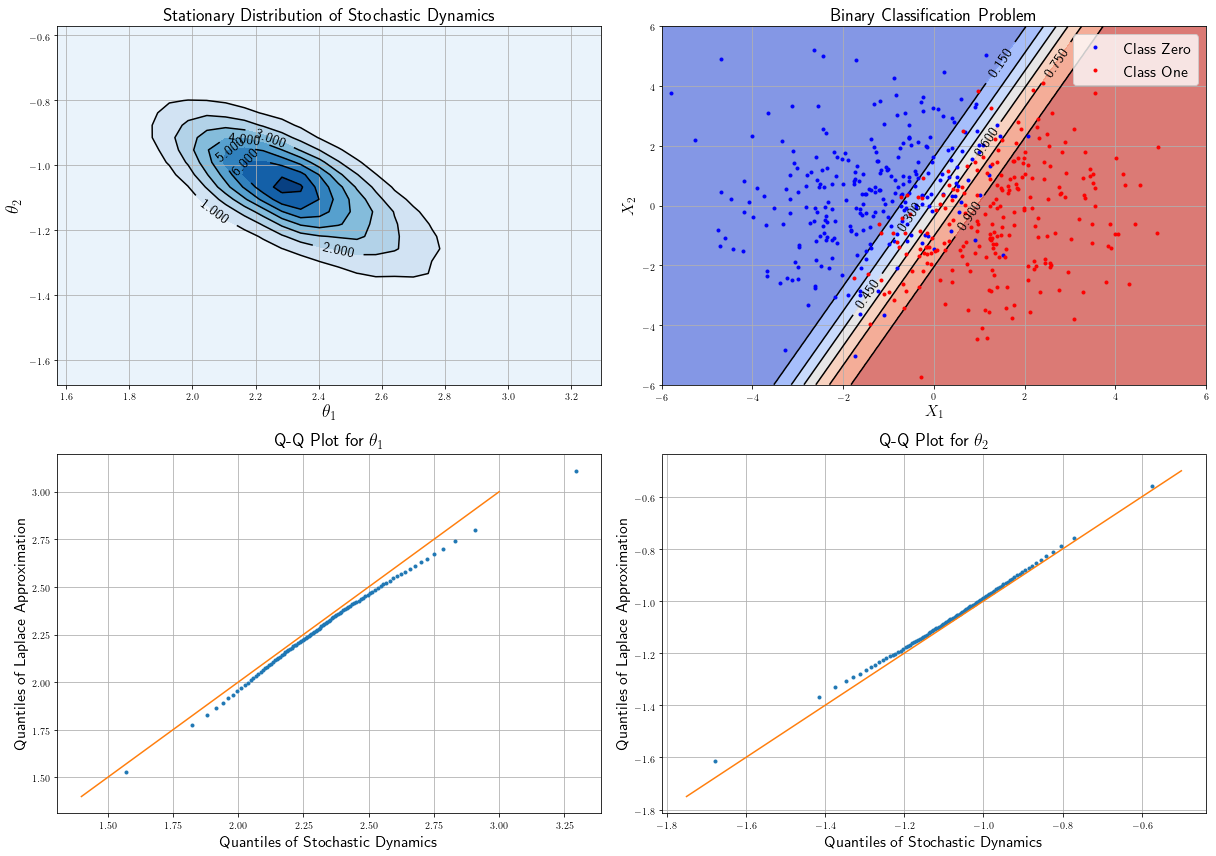

In [18]:
plt.figure(figsize=(17, 12))

# Density plot.
plt.subplot(2, 2, 1)
plt.grid()
plt.contourf(Theta_1_grid, Theta_2_grid, f_grid, cmap='Blues')
cset = plt.contour(Theta_1_grid, Theta_2_grid, f_grid, colors="k")
plt.clabel(cset, inline=1, fontsize=14)
plt.xlabel("$\\theta_1$", fontsize=18)
plt.ylabel("$\\theta_2$", fontsize=18)
plt.title("Stationary Distribution of Stochastic Dynamics", fontsize=18)

# Decision plot.
plt.subplot(2, 2, 2)
plt.contourf(X_1_grid, X_2_grid, p_grid, cmap='coolwarm', alpha=0.7)
cset = plt.contour(X_1_grid, X_2_grid, p_grid, colors="k")
plt.clabel(cset, inline=1, fontsize=14)
plt.plot(X[y==0, 0], X[y==0, 1], "b.", label="Class Zero")
plt.plot(X[y==1, 0], X[y==1, 1], "r.", label="Class One")
plt.grid()
plt.legend(fontsize=16)
plt.xlabel("$X_1$", fontsize=16)
plt.ylabel("$X_2$", fontsize=16)
plt.title("Binary Classification Problem", fontsize=18)
plt.xlim((-6, 6))
plt.ylim((-6, 6))

# Quantile-Quantile plots.
bounds = [[1.4, 3.0], [-1.75, -0.5]]
for i in [0, 1]:
    plt.subplot(2, 2, i+3)
    quantiles = np.linspace(0, 1, 100)
    plt.plot(np.quantile(Theta[:, i], quantiles), 
             np.quantile(S[:, i], quantiles), ".")
    plt.plot(bounds[i], bounds[i], "-")
    plt.grid()
    plt.xlabel("Quantiles of Stochastic Dynamics", fontsize=16)
    plt.ylabel("Quantiles of Laplace Approximation", fontsize=16)
    plt.title("Q-Q Plot for $\\theta_" + str(i+1) + "$", fontsize=18)


plt.tight_layout()
plt.show()